In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn import svm
import warnings; warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, train_test_split
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt

In [2]:
%store -r

In [3]:
%store

Stored variables and their in-db values:
X                       ->       LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFin
X_scaled                ->       LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFin
lasso_top10             -> ['TotLivArea', 'GarageArea', 'BsmtQual', 'ExterQua
lm_df                   ->       LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFin
test_df                 ->       LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFin
train_df                ->       LotFrontage  MasVnrArea  BsmtFinSF1  BsmtFin
y                       -> Id
1       208500
2       181500
3       223500
4 
y_scaled                -> Id
1       0.349000
2       0.008854
3       0.537


### Fitting Regression Models Using Default Settings

### Linear Models: Ridge and Lasso
Ridge and lasso is just ordinary least squares (OLS) linear regression subject to constraints to reduce the variance of the our coefficient estimators. Unlike OLS, it is not unbiased (according to Gauss-Markov Theorem) but when our features are highly correlated, our coefficient estimators have high variance. 

From the $R^{2}$, which is the proportion of the explained variance to the total variance, we see that our dataset is very linear and linear regression is appropriate. Because it is linear, using ANOVA for feature selection/elimination was appropriate. 

Lasso can be preferable to Ridge regression because Lasso usually helps with feature selection. Lasso regression subjects our linear model to the constraint that the L1-norm of our coefficent estimator vector be less than some constant, unlike Ridge regression which uses the L2-norm. The L1-norm is pointy and the optimized linear regression subject to the L1-penalty usually "hits" an edge where coefficient estimators are zero or very small. 
Lasso was not necessary for feature selection in this case as we can see the ridge regression model is nearly identical to the lasso regression model. 

We can see from our coefficent estimators which feature is most useful for predicting sale. price. The larger the coeffient, the larger the "effect" (remember that association does not imply causation).

Note: informal derivation of Ridge and Lasso in doc directory

#### Ridge

0.9420074505900202


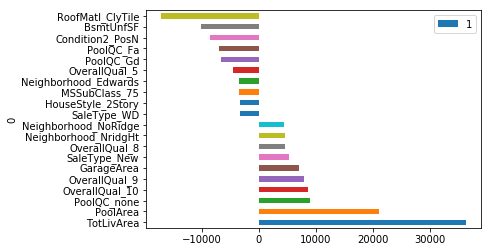

In [4]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y) 

ridge_r2 = ridge.score(X_scaled,y); print(ridge_r2)

ridge.coef_

X_scaled.columns

def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of coefficients
    '''
    cols = X_scaled.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

plot_coef(ridge)

#### Lasso

In [11]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
print(lasso.score(X_scaled,y))
plot_coef(lasso)

0.9420330146841008


#### K-Nearest-Neighbors
KNN groups the data into some number of clusters that we pick. Imagine a two-dimensional dataset plotted. KNN would group them into some number of groups you specify based on their proximity to eachother. The distance can be determined using the Euclidean distance (recall Pythagorean Theorem). That distance formula generalizes to multiple dimensions so we can cluster in an infinite number of dimensions. Note that the distance formula used may be different. 

Using `GridSearchCV`, we see that the most optimal number of clusters is 9. The score for our knn using default settings, n_neighbors = 5, is higher than the score for the best paramater, n=9, because the first score gives us the $R^{2}$ of the training set rather than the validation set. Almost always the score for the training set is higher than the score for the validation set, but the score for the validation set is what's important. 

In [ ]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 5)

In [ ]:
knn.fit(X, y)

In [ ]:
knn.score(X, y)

#### Decision Tree
A decision tree regressor is like the usual decision tree classifier, except in the last node, the regressor predicts the sales price is the average of the subset an observation belongs to. 

In [ ]:
# think of random_state like random seed
dtree_regressor = DecisionTreeRegressor(random_state=0)
print(cross_val_score(dtree_regressor, X, y, cv=10))

#### Support Vector Machines
Support vector machines work by splitting the data with a hyperplane. A hyperplane is a matrix with one-less dimension. For example, a line is a plane's  hyperplane. It's easier to think of it in two-dimensions and then generalize to n-dimensions. Support vector machines divide the dataset with a line. 

note: there's good youtube video on SVM classifiers @ https://youtu.be/N1vOgolbjSc

In [ ]:
svRegression = svm.SVR()
svRegression.fit(X, y)

In [ ]:
svRegression.score(X, y)

Let's try neighbors from 5 to 50 with intervals of 5. Ex: [5,10,15,...,45,50]

In [ ]:
knn_params = {'n_neighbors': range(1,11,1)}

knn_gs = GridSearchCV(knn,
                     param_grid= knn_params,
                     cv = 10,
                     return_train_score = True)

knn_gs.fit(X, y)

#df.T = transpose of df
pd.DataFrame(knn_gs.cv_results_).T

best mean test score from our `cv_results_`; parameters for best mean test score; `best_estimator_` is the actual best model

In [ ]:
best_scr = knn_gs.best_score_; best_param = knn_gs.best_params_
print(best_scr, best_param)
knn_gs.best_estimator_

ridge_params = {'alpha': np.linspace(start=0, stop = 6000, num=101)}

ridge_gs = GridSearchCV(ridge,
                     param_grid= ridge_params,
                     cv = 5,
                     return_train_score = True)

ridge_gs.fit(X, y)
#df.T = transpose of df
display(pd.DataFrame(ridge_gs.cv_results_).T)
best_scr = ridge_gs.best_score_; best_param = ridge_gs.best_params_
print(best_scr, best_param)
ridge_gs.best_estimator_

X_scaled = preprocessing.scale(X.values)
X = pd.DataFrame(X_scaled, index = X.index, columns = X.columns)
y_scaled = preprocessing.scale(y.values)
y = pd.Series(y_scaled, index = y.index, name = y.name)

svRegression_params = {'C': np.linspace(start=0.01, stop = 1, num=20)}

svRegression_gs = GridSearchCV(svRegression,
                     param_grid= svRegression_params,
                     cv = 5,
                     return_train_score = True)

svRegression_gs.fit(X, y)
#df.T = transpose of df
display(pd.DataFrame(svRegression_gs.cv_results_).T)
best_scr = svRegression_gs.best_score_; best_param = svRegression_gs.best_params_
print(best_scr, best_param)
svRegression_gs.best_estimator_

### Complexity/Learning Curves

#### KNN

In [ ]:
# this is a learning curve
test_results = pd.DataFrame(knn_gs.cv_results_)
test_results.param_n_neighbors
test_results.mean_test_score
plt.plot(test_results.param_n_neighbors, test_results.mean_test_score, label='test performance')
plt.plot(test_results.param_n_neighbors, test_results.mean_train_score, label='train performance')
plt.legend()

#### Ridge Regression

In [ ]:
test_results = pd.DataFrame(ridge_gs.cv_results_)
test_results.param_alpha
test_results.mean_test_score
plt.plot(test_results.param_alpha, test_results.mean_test_score, label='test performance')
plt.plot(test_results.param_alpha, test_results.mean_train_score, label='train performance')
plt.legend()

#### Lasso Regression

In [ ]:
test_results = pd.DataFrame(ridge_gs.cv_results_)
test_results.param_alpha
test_results.mean_test_score
plt.plot(test_results.param_alpha, test_results.mean_test_score, label='test performance')
plt.plot(test_results.param_alpha, test_results.mean_train_score, label='train performance')
plt.legend()